## The Main Network

### Making the network
The main network is build upon our analysis on simpler networks, the basic statistics and the text analysis. The first three networks we tried did not yield the desired result so now we are going to merge them together and add some additional information in order to make a smart recommendation engine.

In order to make a link in the network, some similarities between the movies (nodes) must exist. It was decided that what mattered in order to make a link between the networks was: 
 - A ratio of common keywords 
 - A ratio of common genres
 - A ratio of common actors/actresses
 - A ratio of common directors (most often takes the value 0 or 1)
 - In addition to that we looked at IMDb ratings and how similar the storylines of movies are.

For the network we will look at the following:
* What's the maximum and minimum degree?
* How is the degree distribution?
* Visualize the networks.
* Analyze Python-Louvain communities and modularity.
* Look at betweenness centrality.
* Look at clustering coefficients.


## The recommendation engine

We decided to make a network on which to base our recommendation engine. The idea is that a user inputs a name of a movie (node) and from that movie (node) we find all the shortest distances in our network and recommend those movies (nodes) wich are closest in the network. It was decided to use a number of things to build this network, in the pursuit to make as good a recommendation engine as possible. 

We decided to implement a weighted network, since nodes which are connected can have different importance. For example, if we have some movie, lets say 'Iron Man', our network can  have multiple links from that movie. However, these movies (nodes) it links to are not all equally similar to 'Iron Man', and thus we add a weight to the edge. Lastly a movie with few edges can be similar to some movies which are not connected to them directly, but there might be a short path in the network which connects them.     

### Import Libraries



In [6]:
from __future__  import division
import csv
import math
import urllib2
import json
import re
import os
import operator
import calendar
import json
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random
import time
import string
import community

from math import floor, log10
from scipy import spatial
from datetime import datetime
from collections import Counter, defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer

# Function used to round numbers to n significant numbers
def round_sig(x, sig=2):
    return round(x, sig-int(floor(log10(abs(x))))-1)

## Get the datasets

In [7]:
# Get data line by line from tmdb-5000-movie-database and save the data as dictionary
filepath = r"tmdb_5000_credits.csv"
tmdb_5000_credits = defaultdict(dict)

with open(filepath) as csvfile:
    reader = csv.DictReader(csvfile, delimiter=",")
    for row in reader:
        # we take out punctuation and put the data to lower case in order to make it easier to work with the resulting json in
        # the webpage, then we can make the search case and punctuation in-sensitive
        tmdb_5000_credits[row["title"].lower().translate(None, string.punctuation)] = row
        # put the lists and dictonaries to a correct format, (that is not as string)
        tmdb_5000_credits[row["title"].lower().translate(None, string.punctuation)]['cast'] = json.loads(tmdb_5000_credits[row["title"].lower().translate(None, string.punctuation)]['cast'])
        tmdb_5000_credits[row["title"].lower().translate(None, string.punctuation)]['crew'] = json.loads(tmdb_5000_credits[row["title"].lower().translate(None, string.punctuation)]['crew'])
    


for title in sorted(tmdb_5000_credits.keys()):
    title = title.replace(" ","-").replace("(","").replace(")","")

In [8]:
# Get data line by line from tmdb-5000-movie-database and save the data as dictionary

filepath = r"tmdb_5000_movies.csv"
tmdb_5000_movies = defaultdict(dict)

with open(filepath) as csvfile:
    reader = csv.DictReader(csvfile, delimiter=",")
    for row in reader:
        tmdb_5000_movies[row["title"].lower().translate(None, string.punctuation)] = row
        # put the lists and dictonaries to a correct format, (that is not as string)
        tmdb_5000_movies[row["title"].lower().translate(None, string.punctuation)]['genres'] = json.loads(tmdb_5000_movies[row["title"].lower().translate(None, string.punctuation)]['genres'])
        tmdb_5000_movies[row["title"].lower().translate(None, string.punctuation)]['keywords'] = json.loads(tmdb_5000_movies[row["title"].lower().translate(None, string.punctuation)]['keywords'])
        tmdb_5000_movies[row["title"].lower().translate(None, string.punctuation)]['production_companies'] = json.loads(tmdb_5000_movies[row["title"].lower().translate(None, string.punctuation)]['production_companies'])
        
for title in sorted(tmdb_5000_movies.keys()):
    title = title.replace(" ","-").replace("(","").replace(")","")
    


### Calculating similarities between storylines

Previously we had scraped all the storylines from IMDb (that code is available in the notebook 'GetAdditionalData'). Using this information we can calculate the similarities between the storylines. To do this we use TF-IDF and later on use the cosine distance to calculate the similarities.  The TF-IDF gives us a vector for each storyline which tells us how important each word is. This results in a matrix for all the storylines, we then take each vector and calculate the similarity between the storylines later on in the notebook. Note, to be able to acess the correct vectors at a given time we introduce the dictonary which maps each movie with the correct line of the matrix. 

In [11]:
filepath_storyline = "/Users/GretarAtli/Dropbox/SocialGraph/FinalProject/Data/imdb-storyline.json"

# initalize the data
files = []
movie_number = {}

# found by scraping IMDb
# As we had encoding problems with some movies and the last three do not have imdb rating we remove them
movies_to_delete =[
    'National Lampoon’s Van Wilder'.translate(None, string.punctuation),
    'Bran Nue Dae'.translate(None, string.punctuation),
    'Pokémon: Spell of the Unknown'.translate(None, string.punctuation),
    'Alien³'.translate(None, string.punctuation),
    'Guten Tag, Ramón'.translate(None, string.punctuation),
    'xxx: state of the union'.translate(None, string.punctuation),
    'xxx'.translate(None, string.punctuation),
    "Æon Flux".lower()
    
]

# load the data
with open(filepath_storyline) as json_data:
    d = json.load(json_data)



index = 0
for movie in tmdb_5000_movies.keys():
    
    _id = tmdb_5000_movies[movie]['id']
    if d[_id] != 0 and d[_id] != None:
        files.append(d[_id])
        movie_number[movie] = index
        index += 1
    else:
        # if a movie does not have a storyline we throw it
        movies_to_delete.append(movie)
        
# Note that we excluded the stop words from the data because we did not consider it to be relevant
vectorizer = TfidfVectorizer(input = 'content', analyzer='word', min_df = 0, stop_words = 'english')
TF_IDF_matrix = vectorizer.fit_transform(files).todense()

### Building the Network

When making the network various decisions regarding what constraints needed to be fulfilled to make an edge and what the weight of that edge should be. We start the discussion on the constraints. The constraints build upon four dimensions: genre, keywords, actors and director. All of these things are calculated in a similar fashion. We find all the common things in both movies, by their; genres, keywords, actors and directors and then we normalize it by dividing by the movie which has less items in each dimension. 

Each of these values are then multiplied by an importance coefficent, and if the total sum of the dimension varibles is more than 0.3 we make an edge. The value of the importance was choosen by guesswork and trial-and-error. Since there is no correct answer to which movies you recommend we tweaked it until we were happy with the results generated.

There were some things we kept in mind though. Firstly, note that the sum of the dimension varibles can at maximum have the value of 1. Next when looking at the importance coefficent, one can observe that none of them has a value greater than 0.3. This forces our network to make a connection only if at least two dimension variables are shared. 

Next when assigning a weight to the edge we subtract both the sum of the varibles which satisfied the constraint and the similarities between the movies with 1.4 (so we don't get any negative weights). This way, movies that have similar keywords, genre, actors, directors and storylines are closer in the network. 

Note that we use the similarity between storylines only in deciding on the weight of the edge. The reason for this is that altough the movies might have similar storylines the movies could be very different. For example a romance and a horrors story might connect, depending on the language used in the storyline on IMDB. Furthermore, there exists only so few  [storylines]( https://en.wikipedia.org/wiki/The_Seven_Basic_Plots).

After these explanations it should be trivial to understand the following code.

In [12]:
# lets build the network
G = nx.Graph()

# all movies
movies = [movie for movie in tmdb_5000_movies.keys() if movie not in  movies_to_delete]

# add the nodes
G.add_nodes_from(movies)

# ratio of similar keywords that movies have to pass to be consider similar
min_ratio = 0.3
total_ratios = []
links = []
# loop thorugh all the pairs and check if we have enough evidance to insert a link
for i in xrange(len(movies) - 1):
    
    # extract all the keywords from the first movie
    keywords_i = [keyword_i['id'] for keyword_i in tmdb_5000_movies[movies[i]]['keywords']]
    
    # extract the genere from the first movie
    genre_i = [genre_i['id'] for genre_i in tmdb_5000_movies[movies[i]]['genres']]

    # extract all the actors from the first movie
    actors_i = [actor_i['id'] for actor_i in tmdb_5000_credits[movies[i]]['cast']]
    
    # extract all the directors from the first movie
    director_i = [member_i['id'] for member_i in tmdb_5000_credits[movies[i]]['crew'] if member_i['job'] == 'Director']
    
    for j in xrange(i + 1, len(movies)):

        # all the keywords from the second movie
        keywords_j = [keyword_j['id'] for keyword_j in tmdb_5000_movies[movies[j]]['keywords']]
        
        # extract the genere from the second movie
        genre_j = [genre_j['id'] for genre_j in tmdb_5000_movies[movies[j]]['genres']]

        # extract all the actors from the second movie
        actors_j = [actor_j['id'] for actor_j in tmdb_5000_credits[movies[j]]['cast']]

        # extract all the directors from the second movie
        director_j = [member_j['id'] for member_j in tmdb_5000_credits[movies[j]]['crew'] if member_j['job'] == 'Director']
        
        
        
        # ensure that we dont divide by zero
        min_keyword_length = min(len(keywords_i), len(keywords_j))
        if min_keyword_length != 0:
            
            # claculate the keyword ratio of the two movies, using the smaller keywords list
            keyword_ratio = len(set(keywords_i).intersection(set(keywords_j))) / min_keyword_length
        else:
            keyword_ratio = 0.0
            
            
        
                
        #-----------------------------------------------------------------    
                
        # ensure that we dont divide by zero
        min_genre_length = min(len(genre_i), len(genre_j))
        if min_genre_length != 0:
            
            # claculate the keyword ratio of the two movies, using the smaller keywords list
            genre_ratio = len(set(genre_i).intersection(set(genre_j))) / min_genre_length
        else:
            genre_ratio = 0.0
            
        
        #------------------------------------------------------------------------------
        
        # ensure that we dont divide by zero
        min_actors_length = min(len(actors_i), len(actors_j))
        if min_actors_length != 0:
            
            # claculate the keyword ratio of the two movies, using the smaller keywords list
            actors_ratio = len(set(actors_i).intersection(set(actors_j))) / min_actors_length
        else:
            actors_ratio = 0.0
        
            
        #------------------------------------------------------------------------------    
            
        # ensure that we dont divide by zero
        min_director_length = min(len(director_i), len(director_j))
        if min_director_length != 0:
            
            # claculate the keyword ratio of the two movies, using the smaller keywords list
            director_ratio = len(set(director_i).intersection(set(director_j))) / min_director_length
        else:
            director_ratio = 0.0
        
        #------------------------------------------------------------------------------
            
        total_ratio = 0.25 * keyword_ratio + 0.25 * genre_ratio + 0.2 * actors_ratio + 0.3 * director_ratio
        total_ratios.append([keyword_ratio, genre_ratio, actors_ratio, director_ratio])
        
        # if total ratio is more than the 'min_ratio' we insert a edge, between the nodes
        if total_ratio > min_ratio:
            similarity = 1 - spatial.distance.cosine(TF_IDF_matrix[movie_number[movies[i]]], TF_IDF_matrix[movie_number[movies[j]]])
            # the wieght is 1.4 - total_ratio, since if we get higher ratio we are closer in the network, and similarity, if the
            # storylines are similar the films are closer in the network, we chose 1.4 so we dont have any negative weights
            # since calculating the shortest path with dijekstra requiers positive weights
            G.add_edge(movies[i], movies[j], weight = 1.4 - total_ratio - 0.4 * similarity)
            links.append((total_ratio, [keyword_ratio, genre_ratio, actors_ratio, director_ratio] ))



In [7]:
#The size of the network
print "The number of nodes in the network is: {}".format(len(G.nodes()))
print "The number of edges in the network is: {}".format(len(G.edges()))

The number of nodes in the network is: 4794
The number of edges in the network is: 71718


### Maximum, minimum, median and mean degree

In [8]:
# Find the maximum and minimum degree of the network
print "The minimum degree of the network is: {}".format(min(G.degree().values()))
print "The maximum degree of the network is: {}".format(max(G.degree().values()))
print "The median degree of the network is: {}".format(np.median(G.degree().values()))
print "The mean degree of the network is: {}".format(np.mean(G.degree().values()))

The minimum degree of the network is: 0
The maximum degree of the network is: 394
The median degree of the network is: 13.0
The mean degree of the network is: 29.9198998748


Let's see what movie has the highest degrees.

In [20]:
sorted(G.degree().iteritems(), key=operator.itemgetter(1), reverse = True)[0:5]

[('lords of dogtown', 394),
 ('sherrybaby', 391),
 ('the namesake', 387),
 ('clerks ii', 383),
 ('thirteen conversations about one thing', 383)]

When we look at our data we can see why 'Lords of Dogtown' is the biggest hub. It only has 4 keywords and two of them are the two most common, 'woman director' and 'independent film'. As it has so few keywords but popular ones, and we use percentages to create matches, it'll easily get common keywords with a lot of movies. Same goes for genre, in our data 'Lords of Dogtown' only has one genre, 'Drama' which is the most common genre, and it'll easily make a connection to many films there as again we use a factor to determine the commonality. As stated before at least two common factors are needed to make a connection, therefor it is understandable that this is a hub. This is a bit of a limiting factor in our dataset as the volume of information on individual movies can differ quite a bit.

### Degree distribution

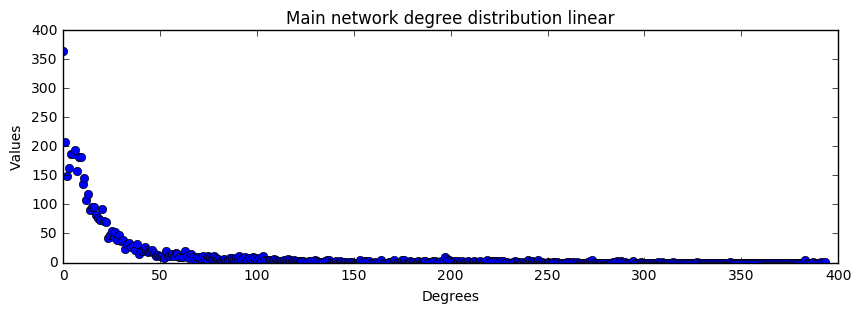

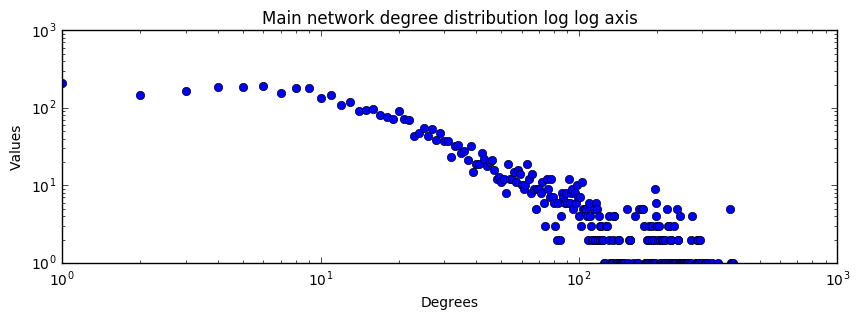

In [15]:
# Plot the distribution, both linear and log-log axes

# bin the degree distribution using np.histogram
values, bins = np.histogram(G.degree().values(), bins=max(G.degree().values()))

# linear plot
plt.figure(num=None, figsize=(10,3), dpi=80, facecolor="w", edgecolor="k")
plt.plot(range(0,len(values)), values,'o')
plt.title("Main network degree distribution linear")
plt.xlabel("Degrees")
plt.ylabel("Values")
plt.show()

# log log plot
plt.figure(num=None, figsize=(10,3), dpi=80, facecolor="w", edgecolor="k")
plt.plot(range(0,len(values)), values,'o')
plt.xscale('log')
plt.yscale('log')
plt.title("Main network degree distribution log log axis")
plt.xlabel("Degrees")
plt.ylabel("Values")
plt.show()

As we can see the degree distribution follows a power law distribution, this tells us that this is a scale-free network. To understand what this is telling us we need to know what scale free network means. A scale free network is a network that contains hubs, hub is a node with an exceptionally large number of links, the scale free networks also has a large number of small degree nodes. This is the main difference between scale free network and a random network. In a random network most nodes have comparable degrees and hence hubs are forbidden and furthermore small degree nodes are mostly of absent in a random network.

Therefore it can be seen that there are hubs in this network meaning that there are small number of movies that are very similar to many other movies but the vast amount of the movies have low degree value which means that they only link to few other movies.

### Visualization of the network

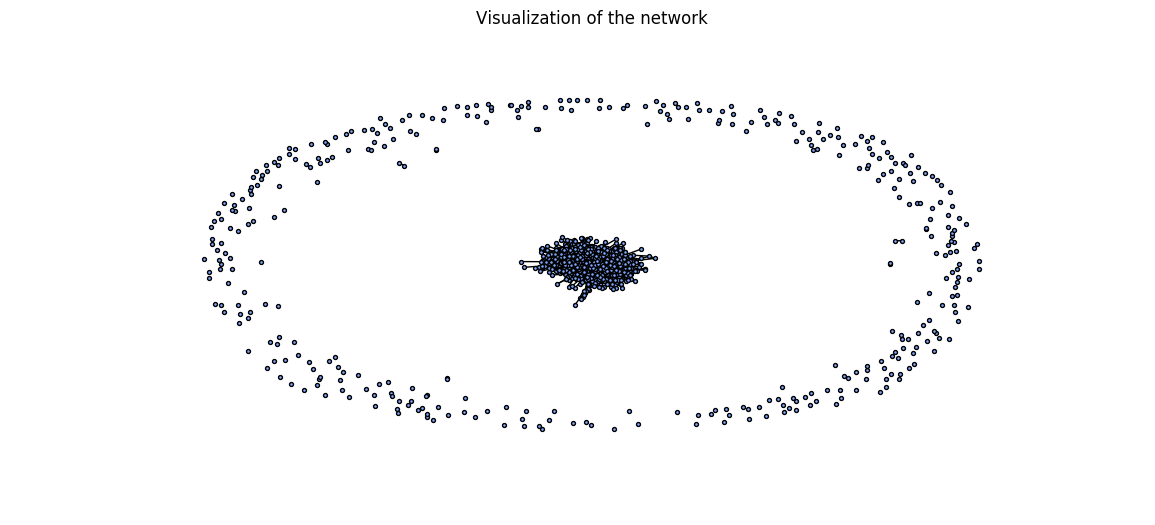

In [22]:
# plot the network
plt.figure(figsize=(14,6))
plt.title('Visualization of the network')
nx.draw_spring(G,node_size = 8, node_color = "#7FA8FF", with_labels = False, edge_color = "black" )
plt.show()

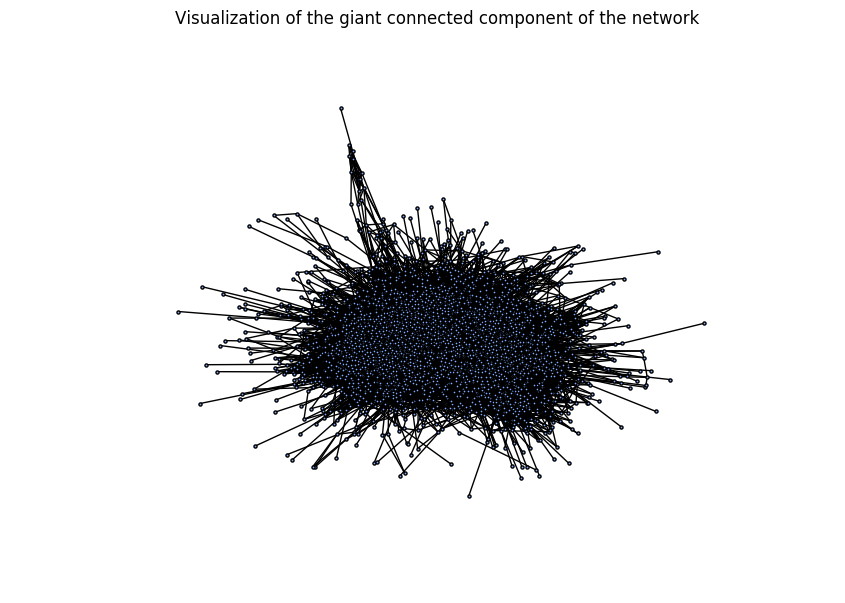

In [28]:
#Let's look at the giant connected component of the network
giant_G = max(nx.connected_component_subgraphs(G), key=len)

# plot the network's giant connected component
plt.figure(figsize=(10,7))
plt.title('Visualization of the giant connected component of the network')
nx.draw_spring(giant_G,node_size = 5, node_color = "#7FA8FF", with_labels = False)
plt.show()

### Analyze Python-Louvain communities and modularity

In [26]:
# First compute the best partition
partition = community.best_partition(giant_G)

# Find how many communities there are in the partition 
communities = Counter([value for key,value in partition.items()])

print "The giant component of the actors network is split up to {} communities".format(len(communities))
print "The modularity of this community division is {}".format(
    community.modularity(partition,giant_G)
)


The giant component of the actors network is split up to 8 communities
The modularity of this community division is 0.592440340994


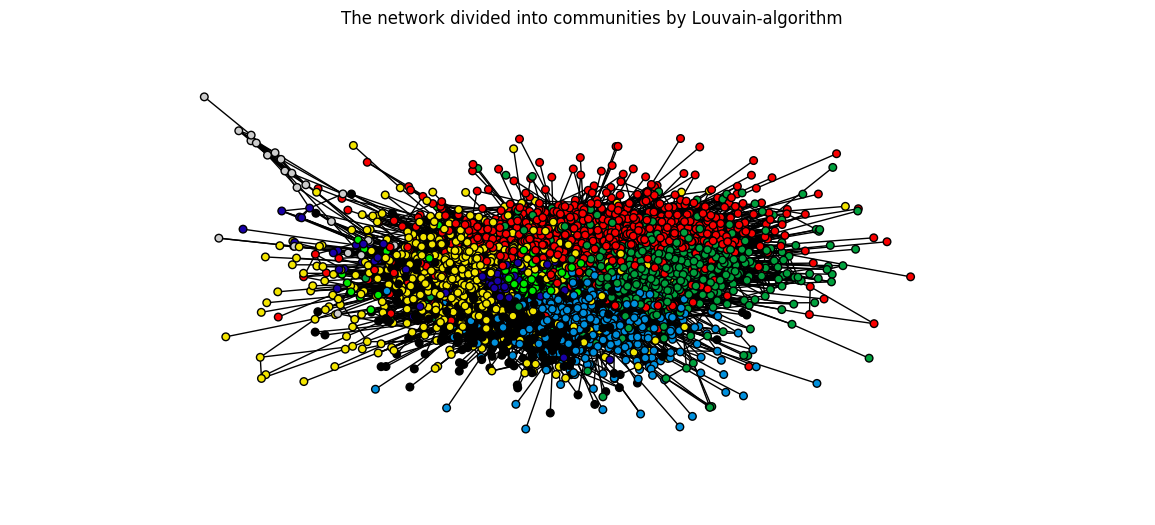

In [27]:
# The network divided into communities by the Louvain-algorithm
plt.figure(figsize=(14,6))
values = [partition.get(node) for node in giant_G.nodes()]
plt.title('The network divided into communities by Louvain-algorithm')
nx.draw_spring(giant_G, cmap = plt.get_cmap('nipy_spectral'), node_color = values, node_size=30, with_labels=False)
plt.show()

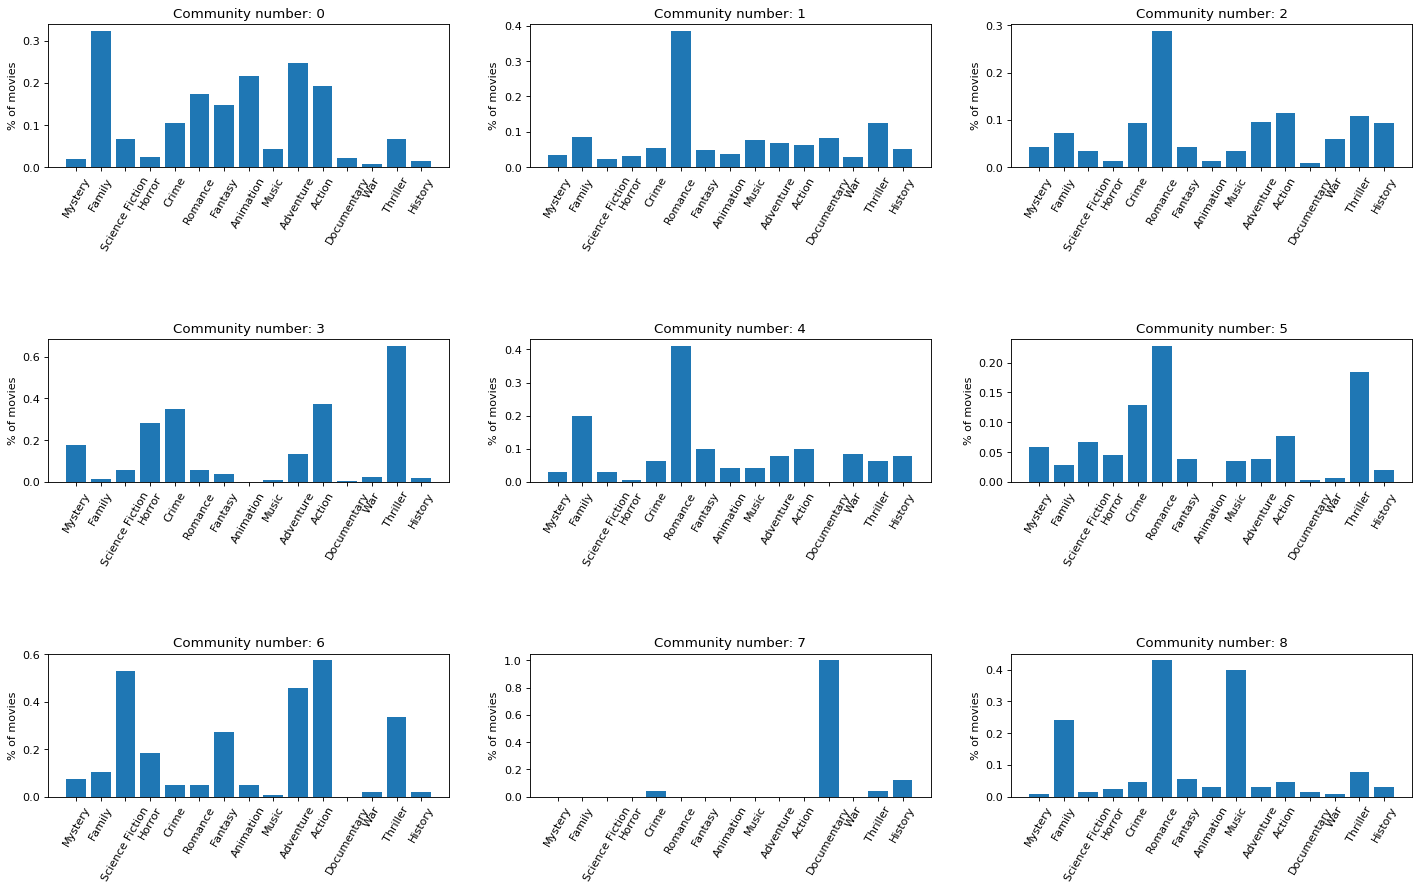

In [15]:
genre_dict = {}
#As most movies have some of the following genres we will not be looking at them
not_interested = [u'Comedy', u'Drama']

#Loop through the partitions
for i in partition:
    #We will create a dictionary for each partition
    if partition[i] not in genre_dict:
        genre_dict[partition[i]] = {}
    for genre in tmdb_5000_movies[i]['genres']:
        #We count the number of genre occurences of the ones we are interested in
        if genre['name'] not in not_interested:
            if genre['name'] in genre_dict[partition[i]]:
                genre_dict[partition[i]][genre['name']] += 1
            else:
                genre_dict[partition[i]][genre['name']] = 1

#We don't want to look at all genres, let's just take the union of the 5 most common genres
names = []
for genre in genre_dict:
    genre_counter = Counter(genre_dict[genre])
    names += [str(x[0]) for x in genre_counter.most_common(5)]

#Plot our findings
names = set(names)
for genre in genre_dict:
    genre_counter = Counter(genre_dict[genre])
    values = [genre_counter[x]/communities[genre] for x in names]
    plt.figure(num=20, figsize=(22, 18), dpi=80, facecolor='w', edgecolor='k')
    plt.subplot(4,3,genre+1)
    plt.bar(range(0,len(names)), values)
    plt.xticks(range(0,len(names)), names, rotation=60)
    plt.title('Community number: ' + str(genre))
    plt.ylabel('% of movies')

plt.subplots_adjust(hspace=1.2)
plt.show()

We can see that we are definitely on to something here, at least in respect to genres. The communities have a correlation to genres. In community 0 we have 'kids' movies, that is 'Family, 'Adventure' and 'Animation'. There are five communities where the majority of the films are labeled as romantic movies, although they differ a bit, e.g. community 8 clearly has romantic music films while the other romantic communities don't. Community 3 is clearly for exciting movies, 'Thriller', 'Action' and 'Crime are high there. In community 6 we have 'Action' movies, also high in 'Sci-fi' and 'Adventure'. Community 7 is almost only documentaries, which is good, if you like to watch documentaries thats where you should look.

### Betweenness centrality

In [16]:
#Calculate the betweenness of the network
betweenness = nx.betweenness_centrality(G)

In [17]:
betweenness_sorted = sorted(betweenness.items(), key=operator.itemgetter(1), reverse=True)

# print out the list of the 5 pages that have the highest centrality :)

print ("{movie_s: <46} {centrality_d: <14}".format(
            movie_s = "Movie:", centrality_d = "Betweenness centrality value:"
        ))

print("------------------------------------------------------------------")

for page, centrality in betweenness_sorted[:5]:
    print ("{movie_s: <46} {centrality_d: <14}".format(
            movie_s = page, centrality_d = round_sig(centrality,5)
        ))

Movie:                                         Betweenness centrality value:
------------------------------------------------------------------
clerks ii                                      0.01705       
winters tale                                   0.014313      
rush hour 2                                    0.014152      
my week with marilyn                           0.012476      
the spy next door                              0.011856      


Here we come back to the limiting factor of our data, the volume of information on individual movies. All these movies have very few but popular keywords, genres or both. As mentioned before this makes it relatively easy for these movies to get links to other movies. It is interesting though that Jackie Chan plays the main character in two of those movies.

### Clustering coefficients

In [18]:
print "The clustering coefficent for the network is: {}".format(nx.average_clustering(G))

The clustering coefficent for the network is: 0.347503313716


In [19]:
print "The clustering coefficent for the GCC of the network is: {}".format(nx.average_clustering(giant_G))

The clustering coefficent for the GCC of the network is: 0.378105058092


### Looking at the results

To test our network we looked at the neighbors of one known movie. The movie that we chose to look at is the awesome movie 'Iron Man 2'. The result can be seen here below.

In [20]:
sor = []
for key in G['iron man 2'].keys():
    sor.append((G['iron man 2'][key]['weight'], key))

#For the sake of the notebook length let's print the 5 top results
for movie in sorted(sor)[:5]:
    print movie

(0.47457941494519651, 'iron man')
(0.81190102008266174, 'iron man 3')
(0.91612143975999416, 'captain america civil war')
(0.93152758296692273, 'zathura a space adventure')
(0.93829986540305765, 'avengers age of ultron')


Looking at the results we can see that all of them make a lot of sense. It might seem suprising that for 'Iron Man 2' our engine recommends 'Zathura: A Space Adventure', but it turns out that they have the same director and genre among other things. The other four movies are a great match. 'Iron Man' is a trilogy and we get the two missing films recommended in the first two spots. We then get 'Captain America: Civil War' which is, like 'Iron Man 2', a Marvel superhero flick and 'Iron Man' (the same character and same actor) features heavily in the movie. Same goes for 'Avengers: Age Of Ultron'.

## Conclusion
We can see that this network turns out to be quite good for our recommendation engine, we have almost all of our 5000 movies in the network, the cluster coefficient is 0.348 and modularity of our communities is 0.592 which is quite high, especially considering there are only 9 communities. Testing the recommendation engine proves that this works quite well and we're pleased with the results. Deciding which properties and their weight to use took some time and was mostly fine tuned through trial-and-error.

### Creating recommendation data for each movie
 
Now we have a network that connects similar movies together. What we want to do next is to find the shortest path from all movies to all other movies in the network. To accomplish this we used *Djikstra shortest path*: The algorithm creates a tree of shortest paths from the starting vertex, the source, to all other points in the graph.

To further improve the recommendation, after having calculated the shortest path, we added the IMDb rating to the mix. We would rather recommend a highly rated movie. 

In [21]:
movies_in_network = []
for _movie in movies:
    shortest_paths = nx.single_source_dijkstra_path_length(G, _movie)
    movies_in_network.append(shortest_paths)      

### Add the IMDb rating

It was decided to use the IMDb rating to shorten the distances. This will yield a shorter distance to movies which have higher IMDb rating. This should improve our search engine, since most people want to see highly rated movies rather than bad ones. 

In [22]:
# get the imdb scores
with open("imdb-score.json") as data_file:    
    IMBD_ratings = json.load(data_file)


imdb_importance = 0.15
all_possible_recommendations = []
num_options = 10
need_more_recommendations = []

for m in movies_in_network:
    sorted_distances = sorted(m.items(), key=operator.itemgetter(1))
    possible_recommendations = []
    
    for movie_distance in sorted_distances[1:]:
        # take all the elements which can be in top ten after the imdb rating is added to the network
        if len(possible_recommendations) < num_options or  sorted_distances[num_options - 1][1] > movie_distance[1] - imdb_importance:
            # get the imdb rating
            _id = tmdb_5000_movies[movie_distance[0]]['id']
            
            normalized_raiting =  imdb_importance * float(IMBD_ratings[_id]) / 10
          
            
            # calculate the new reccomandation value and store it, put it to a nice form to easly sort and change to dict l8ter on
            movie_distance = [movie_distance[1] - normalized_raiting, movie_distance[0]]
            possible_recommendations.append(movie_distance)
        else:
            # the movies here after are not good enough recommendation for our network
            break
    if len(possible_recommendations) < num_options:
        need_more_recommendations.append(sorted_distances[0][0])
    all_possible_recommendations.append((sorted_distances[0][0], possible_recommendations))

### Sort the recommendations

In [23]:
# change the format
all_possible_recommendations = dict(all_possible_recommendations)

for key in all_possible_recommendations:
    all_possible_recommendations[key] = sorted(all_possible_recommendations[key])[0:num_options]

### Movies that don't have any/enough links
Some movies (nodes) do not have any links. However, we still want to recommend movies when people like to find similar movies to them.  In this case we depend only on the IMDb rating and the similarity between the movies' storylines. Thus we will only recommend a movie which should be somewhat similar and has a good IMDb rating. (Note that the distance here is calculated as 3 minus the rating and the similarity. The reason for the 3 is that, if some of these movies have only connection to one movie (they are an island) then we want that to be our first chose. Therefore we use 3 so that the value of the edge will never go below 1.)

In [24]:
for first_movie in need_more_recommendations:
    for second_movie in movies:
        second_id = tmdb_5000_movies[second_movie]['id']
        normalized_rating = 0.9 * float(IMBD_ratings[_id]) / 10
        similarity = 1 - spatial.distance.cosine(TF_IDF_matrix[movie_number[first_movie]], TF_IDF_matrix[movie_number[second_movie]])
        # here we put the "distance" to the nodes which are not in the network, we choose to subtract from
        # 3 so we dont get better disntaance than of the movies which arer in the network
        movie_distance = [3 - normalized_rating - 0.7 * similarity, second_movie]
        all_possible_recommendations[first_movie].append(movie_distance)
    all_possible_recommendations[first_movie] = sorted(all_possible_recommendations[first_movie])[:num_options]

### Conclusion

We have gone over, in details, all of the steps of our recommendation engine:
 - create a weighted graph and then calculate the shortest distance from each movie to all other movies
 - shorten the distances based on IMDb ratings
 - Handle movies that don't have any/enough links

Then for each movie the recommendation engine will recommend the x (you can choose how many) movies that have the shortest path to the inputted movie.

### Make the json data of our completed recommendation

As we want to allow users to use the recommendation engine on our website we need to gather all the data and all results relevant and save it to json format. That way we can query it later through our JavaScript.

In [25]:
with open('search_results3.json', 'w') as fp:
    json.dump(all_possible_recommendations, fp)

### Get json data for the movies in our network
This is done for the autocomplete search function that we use on the website. We do that so users won't be making typos when searching for movies as well as just making the life of the user a bi easier.

In [26]:
# Get data line by line from tmdb-5000-movie-database and save the data as list
filepath = r"tmdb_5000_credits.csv"
_movies_in_network = []
_movies_in_network_json_format = {}
with open(filepath) as csvfile:
    reader = csv.DictReader(csvfile, delimiter=",")
    for row in reader:
        if row['title'] not in movies_to_delete:
            _movies_in_network.append(row["title"])
            
_movies_in_network_json_format['movies'] = _movies_in_network

with open('all_movies.json', 'w') as fp:
    json.dump(_movies_in_network_json_format, fp)